## Histopathologic Cancer Detection Project
### 11/27/2024
### Sean Diab

In this project I am going to be doing this Kaggle competition: https://www.kaggle.com/competitions/histopathologic-cancer-detection/

Imports:

In [ ]:
import cv2
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Load the data

In [ ]:
train_labels_path = "train_labels.csv"
train_folder = "./train"
test_folder = "./test"

train_labels = pd.read_csv(train_labels_path)

print(train_labels.head())

print(f"Number of training images: {len(train_labels)}")

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Number of training images: 220025


Visualize a few images

A label of 0 means the image does not contain metastatictumor tissue, a label of 1 means it does contain metastatic tumor tissue.

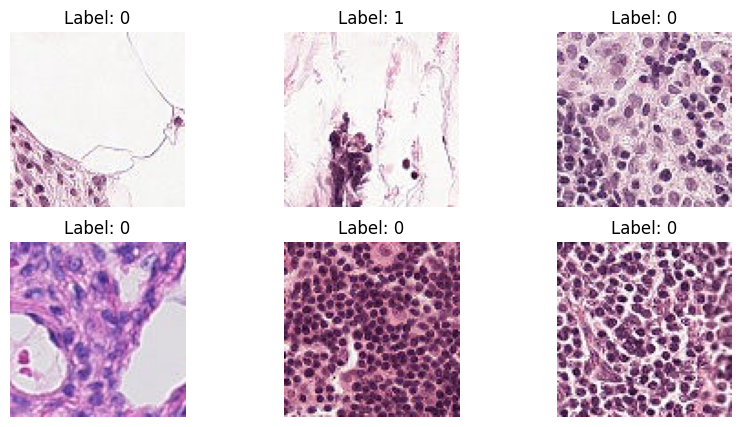

In [ ]:
plt.figure(figsize=(10, 5))

sample_ids = train_labels['id'].values[:6]
sample_labels = train_labels['label'].values[:6]

for i, image_id in enumerate(sample_ids):
    img_path = os.path.join(train_folder, image_id + '.tif')
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {sample_labels[i]}")
    plt.axis("off")

plt.show()

Preprocess the data
Prepare the images and labels for training

In [ ]:
def preprocess_image(image_id, folder, target_size=(32, 32)):
    img_path = os.path.join(folder, image_id + '.tif')
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    return img

def load_images_parallel(image_ids, folder, target_size=(32, 32)):
    with ThreadPoolExecutor() as executor:
        images = list(executor.map(lambda x: preprocess_image(x, folder, target_size), image_ids))
    return np.array(images)

train_ids = train_labels['id'].values
train_images = load_images_parallel(train_ids, train_folder)
train_labels = train_labels['label'].values

train_images = train_images / 255.0

X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 176020
Validation set size: 44005


Building and Training the models

Make a simple CNN model for binary classification

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)

c:\Users\chees\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - AUC: 0.8282 - loss: 0.4970 - val_AUC: 0.8870 - val_loss: 0.4265
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - AUC: 0.8801 - loss: 0.4261 - val_AUC: 0.9042 - val_loss: 0.3835
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - AUC: 0.8990 - loss: 0.3929 - val_AUC: 0.9164 - val_loss: 0.3603
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - AUC: 0.9070 - loss: 0.3780 - val_AUC: 0.9190 - val_loss: 0.3569
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - AUC: 0.9142 - loss: 0.3645 - val_AUC: 0.9205 - val_loss: 0.3556
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - AUC: 0.9208 - loss: 0.3511 - val_AUC: 0.9204 - val_loss: 0.3545
Epoch 7/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - AUC: 0.9229 - loss: 0.3470 - val_AUC: 0.9232 - val_loss: 0.3627
Epoch 8/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - AUC: 0.9270 - loss: 0.3384 - val_AUC: 0.9243 - val_loss: 0.3506
Epoch 9/10
2751/2751 ━━━

Evaluate the model

In [ ]:
val_loss, val_auc = model.evaluate(X_val, y_val)
print(f"Validation AUC: {val_auc}")

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9316 - loss: 0.3359
Validation AUC: 0.9299765825271606


Visualize training progress

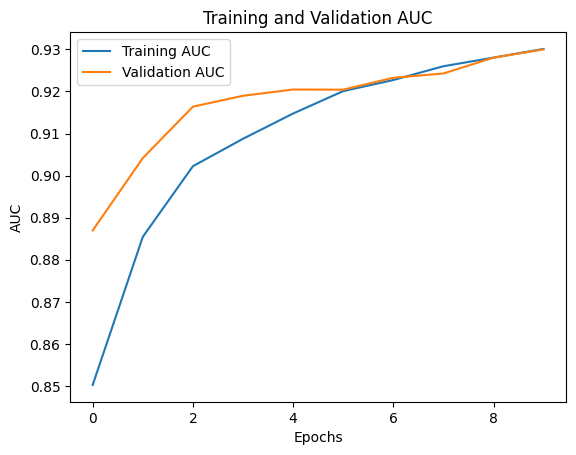

In [ ]:
plt.plot(history.history['AUC'], label='Training AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('Training and Validation AUC')
plt.show()

Save the results to 'submission.csv'.

In [ ]:
test_ids = [os.path.splitext(f)[0] for f in os.listdir(test_folder)]
test_images = load_images_parallel(test_ids, test_folder)
test_images = test_images / 255.0

test_predictions = model.predict(test_images)

submission = pd.DataFrame({
    'id': test_ids,
    'label': test_predictions.flatten()
})

submission.to_csv('submission.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


This model gave me a Private score of 0.8330 and a public score of 0.8986. I am now going to try another model which is a fine tuned version of EfficientNetB0.  

Use another model

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 166s 29ms/step - AUC: 0.5027 - loss: 0.6789 - val_AUC: 0.5000 - val_loss: 0.6750
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 154s 28ms/step - AUC: 0.5007 - loss: 0.6756 - val_AUC: 0.5000 - val_loss: 0.6750
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 153s 28ms/step - AUC: 0.4972 - loss: 0.6744 - val_AUC: 0.5000 - val_loss: 0.6751
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 154s 28ms/step - AUC: 0.4989 - loss: 0.6752 - val_AUC: 0.5000 - val_loss: 0.6751
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 153s 28ms/step - AUC: 0.4997 - loss: 0.6743 - val_AUC: 0.5000 - val_loss: 0.6750
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 154s 28ms/step - AUC: 0.4991 - loss: 0.6759 - val_AUC: 0.5000 - val_loss: 0.6751
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 154s 28ms/step - AUC: 0.4988 - loss: 0.6747 - val_AUC: 0.5000 - val_loss: 0.6751
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 153s 28ms/step - AUC: 0.4986 - loss: 0.6751 - 

Unfreeze and fine-tune the pre-trained layers

In [ ]:
for layer in base_model.layers:
    layer.trainable = True



model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['AUC'])

history_fine_tune = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 707s 124ms/step - AUC: 0.6237 - loss: 0.9244 - val_AUC: 0.7955 - val_loss: 0.5465
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 673s 122ms/step - AUC: 0.7687 - loss: 0.5778 - val_AUC: 0.8370 - val_loss: 0.4976
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 673s 122ms/step - AUC: 0.8157 - loss: 0.5199 - val_AUC: 0.8556 - val_loss: 0.4695
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 685s 124ms/step - AUC: 0.8361 - loss: 0.4922 - val_AUC: 0.8670 - val_loss: 0.4534
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 686s 125ms/step - AUC: 0.8495 - loss: 0.4732 - val_AUC: 0.8692 - val_loss: 0.4702
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 664s 121ms/step - AUC: 0.8611 - loss: 0.4558 - val_AUC: 0.8821 - val_loss: 0.4335
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 670s 122ms/step - AUC: 0.8708 - loss: 0.4410 - val_AUC: 0.8908 - val_loss: 0.4235
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 666s 121ms/step - AUC: 0.8791 - loss: 0.4274 - val_AUC: 0.8991 - val_loss: 0.3962
Epoch 9/

Evaluate the model

In [ ]:
val_loss, val_auc = model.evaluate(X_val, y_val)
print(f"Validation AUC after fine-tuning: {val_auc}")

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - AUC: 0.9074 - loss: 0.3933
Validation AUC after fine-tuning: 0.9053428173065186


Visualize the training progress

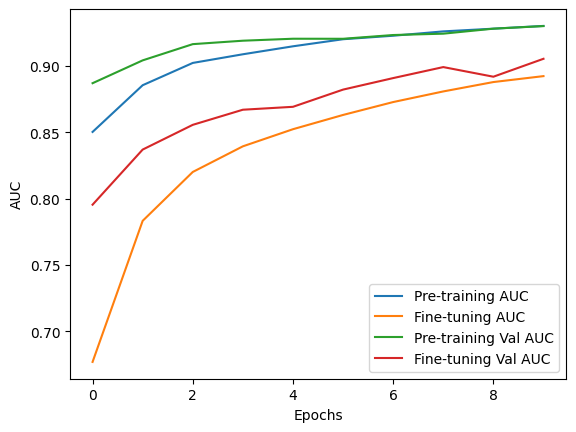

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['AUC'], label='Pre-training AUC')
plt.plot(history_fine_tune.history['AUC'], label='Fine-tuning AUC')
plt.plot(history.history['val_AUC'], label='Pre-training Val AUC')
plt.plot(history_fine_tune.history['val_AUC'], label='Fine-tuning Val AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

Generate predictions on the test data

In [ ]:
def preprocess_test_images(image_ids, test_folder, target_size=(32, 32)):
    images = []
    for image_id in image_ids:
        img_path = os.path.join(test_folder, image_id + '.tif')
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

test_ids = [os.path.splitext(f)[0] for f in os.listdir(test_folder)]

test_images = preprocess_test_images(test_ids, test_folder=test_folder)

Make predictions

In [ ]:
test_predictions = model.predict(test_images).flatten()

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step


Prepare the submission file

In [ ]:
submission = pd.DataFrame({
    'id': test_ids,
    'label': test_predictions
})

submission.to_csv('submission.csv', index=False)

Analyze predictions

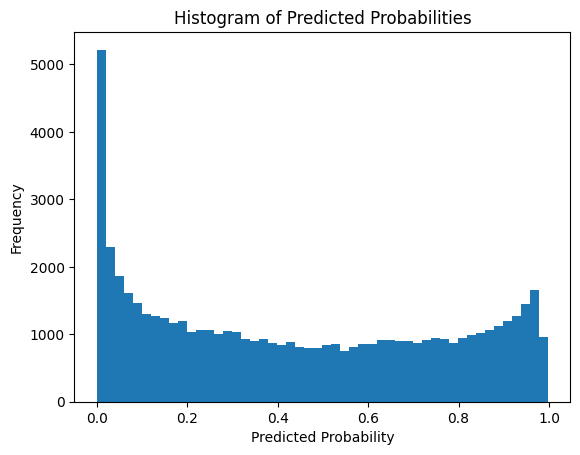

In [19]:
plt.hist(test_predictions, bins=50)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

### Results:

My private score for this model was 0.8377 and my public score was 0.8785.